# Imports

In [94]:
import websocket
import pandas as pd
import requests
from pandas.io.json import json_normalize
import json
from code_ref import get_keys
from code_ref import findata
from code_ref import FinnhubRequestException
from code_ref import FinnhubAPIException
import time
import threading
%matplotlib inline
%load_ext autoreload
%autoreload 2
from ratelimit import limits
from ratelimiter import RateLimiter
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob

from sklearn.experimental import enable_iterative_imputer  
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold
import scipy.cluster.hierarchy as shc



import websocket
import pandas as pd
import requests
from pandas.io.json import json_normalize
import json
from code_ref import get_keys
from code_ref import findata
from code_ref import FinnhubRequestException
from code_ref import FinnhubAPIException
import time
import threading
%matplotlib inline
%load_ext autoreload
%autoreload 2
from ratelimit import limits
from ratelimiter import RateLimiter
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Collection

## Ticker List 

In [14]:
tickers = pd.read_csv('Ticker_list_1.csv')
tickers.drop(tickers[tickers['Exchange'] == 'PNK'].index, inplace = True)
drop = ['Argentina', 'Brazil', 'Estonia', 'Greece', 'Iceland', 'India', 'Indonesia', 'Latvia', 'Lithuania', 'Malaysia', 'Mexico', 'New Zealand', 'Qatar', 'Russia', 'Taiwan', 'Thailand', 'Turkey','China','Switzerland']
drop1 = ['MUN', 'STU', 'DUS', 'HAM', 'HAN', 'EUX', 'FRA', "ENX", 'BER', 'CNQ', 'VAN', 'IOB', 'KOE', 'PCX', 'OBB']
tickers.dropna(subset = ['Country'], inplace = True)

In [15]:
for values in drop:
    tickers.drop(tickers[tickers['Country'] == values].index, inplace = True)
for exch in drop1: 
    tickers.drop(tickers[tickers['Exchange'] == exch].index, inplace = True)

In [16]:
tickers['Category Name'].fillna(1, inplace = True)
drop2 = tickers[ (tickers['Category Name'] == 1)].index
tickers.drop(drop2, inplace = True)

In [20]:
tickers.drop_duplicates(subset = 'Name', keep = 'first', inplace = True)
tickers.sample()

,Ticker,Name,Exchange,Category Name,Country
2298,EBR,Centrais Elétricas Brasileiras S.A. - Eletrobras,NYQ,Electric Utilities,USA


In [71]:
tickers.to_csv('tickers_final.csv')

In [29]:
tick = list(tickers.Ticker[:10])

## Financial Metric Collection

In [33]:
keys = get_keys("/Users/augustingoudet/.secret/code_file") #Finnhub Key
api_key1 = keys ['finnhub'] #api_key
query = findata(api_key = api_key1)
rate_limiter = RateLimiter(max_calls=45, period=60)

In [36]:
url = "https://finnhub.io/api/v1/"
ext1 = "?symbol={}&token={}"
ext2 = "?symbol={}&metric=management&token={}"
ext3 = "?symbol={}&metric=margin&token={}"
ext4 = "?symbol={}&metric=growth&token={}"
ext5 = "?symbol={}&metric=price&token={}"
ext6 = "?symbol={}&metric=valuation&token={}"
ext7 = "?symbol={}&metric=financialStrength&token={}"
ext8 = "?symbol={}&metric=perShare&token={}"
metric= "stock/metric"

In [41]:
results = []

for items in tick:
    with rate_limiter:
        data = url + metric + ext2.format(items, api_key1)
        req = requests.get(data).json()
        with open ('backup/mgmt2.py', 'a+') as f:
            json.dump(req,f)
            results.append(req)
            m1 = json_normalize(results)
m1.to_csv('data_api/management.csv')
m1.sample()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.


,metricType,symbol,metric.assetTurnoverAnnual,metric.assetTurnoverTTM,metric.inventoryTurnoverAnnual,metric.inventoryTurnoverTTM,metric.netIncomeEmployeeAnnual,metric.netIncomeEmployeeTTM,metric.receivablesTurnoverAnnual,metric.receivablesTurnoverTTM,...,metric.revenueEmployeeTTM,metric.roaRfy,metric.roaa5Y,metric.roae5Y,metric.roaeTTM,metric.roeRfy,metric.roeTTM,metric.roi5Y,metric.roiAnnual,metric.roiTTM
5,management,MO,0.47952,0.47952,5.36202,5.36202,-155641,-166027,170.816,170.816,...,3439726,-2.31834,14.8161,63.8761,-11.55695,-11.57599,-2.31452,19.2954,-3.22928,-3.22396


In [42]:
results = []

for items in tick: 
    with rate_limiter:
        data = url + metric + ext3.format(items, api_key1)
        req = requests.get(data).json()
        with open ('backup/margin2.py', 'a+') as f:
            json.dump(req,f)
        results.append(req)
        m2 = json_normalize(results)
m2.to_csv('data_api/margin2.csv')
m2.sample()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.


,metricType,symbol,metric.freeOperatingCashFlow/revenue5Y,metric.freeOperatingCashFlow/revenueTTM,metric.grossMargin5Y,metric.grossMarginAnnual,metric.grossMarginTTM,metric.netProfitMargin%Annual,metric.netProfitMargin5Y,metric.netProfitMarginTTM,metric.operatingMargin5Y,metric.operatingMarginAnnual,metric.operatingMarginTTM,metric.pretaxMargin5Y,metric.pretaxMarginAnnual,metric.pretaxMarginTTM
0,margin,AAPL,19.4091,18.63398,38.7182,37.8178,37.9471,21.23809,21.8983,21.49072,27.1868,24.57202,24.71319,27.9499,25.26655,25.30941


In [47]:
results = []

for items in tick: 
    with rate_limiter:
        data = url + metric + ext4.format(items, api_key1)
        req = requests.get(data).json()
        with open ('backup/growth2.py', 'a+') as f:
            json.dump(req,f)
        results.append(req)
        m3 = json_normalize(results)
m3.to_csv('data_api/growth.csv')
m3.sample()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.


,metricType,symbol,metric.bookValueShareGrowth5Y,metric.capitalSpendingGrowth5Y,metric.dividendGrowthRate5Y,metric.ebitdaCagr5Y,metric.ebitdaInterimCagr5Y,metric.epsGrowth3Y,metric.epsGrowth5Y,metric.epsGrowthQuarterlyYoy,metric.epsGrowthTTMYoy,metric.focfCagr5Y,metric.netMarginGrowth5Y,metric.revenueGrowth3Y,metric.revenueGrowth5Y,metric.revenueGrowthQuarterlyYoy,metric.revenueGrowthTTMYoy,metric.revenueShareGrowth5Y,metric.tbvCagr5Y,metric.totalDebtCagr5Y
4,growth,GOOGL,13.8949,16.4131,,17.2445,17.6616,20.8173,19.9201,20.23469,12.541,20.8607,0.55786,21.48595,19.651,17.31083,18.30009,19.2549,16.4113,-2.75616


In [50]:
results = []

for items in tick: 
    with rate_limiter:
        data = url + metric + ext7.format(items, api_key1)
        req = requests.get(data).json()
        with open ('backup/financialstrength2.py', 'a+') as f:
            json.dump(req,f)
        results.append(req)
        m6 = json_normalize(results)
        m6.dropna(inplace=True)
m6.to_csv('data_api/financialstrength.csv')
m6.sample()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.


,metricType,symbol,metric.currentEv/freeCashFlowAnnual,metric.currentEv/freeCashFlowTTM,metric.currentRatioAnnual,metric.currentRatioQuarterly,metric.freeCashFlowAnnual,metric.freeCashFlowTTM,metric.longTermDebt/equityAnnual,metric.longTermDebt/equityQuarterly,metric.netInterestCoverageAnnual,metric.netInterestCoverageTTM,metric.payoutRatioAnnual,metric.payoutRatioTTM,metric.quickRatioAnnual,metric.quickRatioQuarterly,metric.totalDebt/totalEquityAnnual,metric.totalDebt/totalEquityQuarterly
1,financialStrength,BAC,,,,,55843,55843,81.79525,81.79525,,,23.6403,23.6403,,,161.458,161.458


In [51]:
results = []

for items in tick: 
    with rate_limiter:
        data = url + metric + ext6.format(items, api_key1)
        req = requests.get(data).json()
        with open ('backup/valuation2.py', 'a+') as f:
            json.dump(req,f)
        results.append(req)
        m5 = json_normalize(results)
        m5.dropna(inplace=True)
m5.to_csv('data_api/valuation1.csv')
m5.sample()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.


,metricType,symbol,metric.currentDividendYieldTTM,metric.dividendYield5Y,metric.dividendYieldIndicatedAnnual,metric.netDebtAnnual,metric.netDebtInterim,metric.pbAnnual,metric.pbQuarterly,metric.pcfShareTTM,...,metric.peExclExtraTTM,metric.peExclLowTTM,metric.peInclExtraTTM,metric.peNormalizedAnnual,metric.pfcfShareAnnual,metric.pfcfShareTTM,metric.psAnnual,metric.psTTM,metric.ptbvAnnual,metric.ptbvQuarterly
5,valuation,MO,8.66079,4.39064,8.98156,25925,25925,11.17118,11.17118,,...,,7.93118,,12.5675,45.6778,45.6778,2.76868,2.76868,,


# DataSet Construction

## Dataset:
   - findata frame will be used for scaling and modelling purposes

In [54]:
findata = pd.read_csv('metric_final_set.csv')

In [55]:
findata.drop(columns = ['Unnamed: 0'] , inplace = True)

## KNN Imputer to fill Null Values
   - We elected KNNImputer to fill in missing values with the rationale that similar companies in terms of ratios would be grouped within the matrix dimensions and provide accurate inputs that would not affect the clustering outcomes. 

In [83]:
X = findata.iloc[:,1:89]
y_full = findata.iloc[:,1:89]
N_SPLITS = 5


In [60]:
imputer = KNNImputer(n_neighbors = 20)

In [61]:
comb2 = imputer.fit_transform(X)

In [62]:
comb2

array([[7.38880000e-01, 7.49460000e-01, 4.01344600e+01, ...,
        1.55768000e+00, 1.19404800e+02, 1.21670700e+02],
       [6.29504500e-01, 6.14567000e-01, 9.11558750e+00, ...,
        5.24087000e-01, 1.61458000e+02, 1.61458000e+02],
       [1.44638000e+00, 1.44637000e+00, 8.78851000e+00, ...,
        8.63630000e-01, 6.73799500e+01, 6.73799500e+01],
       ...,
       [4.59832000e+00, 4.59832000e+00, 9.58863000e+00, ...,
        7.07650000e-01, 8.16128100e+01, 8.16128100e+01],
       [1.13807000e+00, 1.06326000e+00, 8.13695000e+00, ...,
        2.61130000e-01, 8.12866000e+00, 9.46215000e+00],
       [4.28800000e-01, 3.46300000e-01, 3.89363545e+01, ...,
        9.68392000e-01, 3.36664100e+03, 1.82633639e+03]])

In [69]:
findata2 = pd.DataFrame(comb2, index = [findata.index, findata.iloc[:,0]], columns = X.columns)
findata2.reset_index(inplace = True)
findata2.drop(findata2.columns[0], axis = 1, inplace = True)

#### Clean dataframe with ticker fields - Full Name / Sector / Country / Exchange

In [81]:
tickers_final = pd.read_csv('tickers_final.csv')
tickers_final.drop(columns = ['Unnamed: 0'], inplace = True)

In [153]:
findata3 = findata2.merge(ticker_final, left_on = 'symbol', right_on = 'Ticker', how = 'left').drop(columns =['Unnamed: 0'])

In [156]:
findata3.columns

Index(['symbol', 'metric.assetTurnoverAnnual', 'metric.assetTurnoverTTM',
       'metric.inventoryTurnoverAnnual', 'metric.inventoryTurnoverTTM',
       'metric.netIncomeEmployeeAnnual', 'metric.netIncomeEmployeeTTM',
       'metric.receivablesTurnoverAnnual', 'metric.receivablesTurnoverTTM',
       'metric.revenueEmployeeAnnual', 'metric.revenueEmployeeTTM',
       'metric.roaRfy', 'metric.roaa5Y', 'metric.roae5Y', 'metric.roaeTTM',
       'metric.roeRfy', 'metric.roeTTM', 'metric.roi5Y', 'metric.roiAnnual',
       'metric.roiTTM', 'metric.freeOperatingCashFlow/revenue5Y',
       'metric.freeOperatingCashFlow/revenueTTM', 'metric.grossMargin5Y',
       'metric.grossMarginAnnual', 'metric.grossMarginTTM',
       'metric.netProfitMargin%Annual', 'metric.netProfitMargin5Y',
       'metric.netProfitMarginTTM', 'metric.operatingMargin5Y',
       'metric.operatingMarginAnnual', 'metric.operatingMarginTTM',
       'metric.pretaxMargin5Y', 'metric.pretaxMarginAnnual',
       'metric.pretaxMar

## Iterative Imputer & Fancy Impute

#### IterativeTest

In [15]:
N_SPLITS = 5
rng = np.random.RandomState(0)

In [16]:
X1 = X.dropna().to_numpy()
X_full = X.to_numpy() #taking continuous subset of variables
y_full = X['metric.assetTurnoverAnnual'].to_numpy()

n_samples, n_features = X_full.shape
REGRESSOR = RandomForestRegressor(random_state=0)


In [120]:
imp_mean = IterativeImputer(estimator = dt, random_state=0)

In [121]:
imp_mean.fit(X_full)

/anaconda3/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


IterativeImputer(add_indicator=False,
                 estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                                 max_depth=None,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 presort='deprecated',
                                                 random_state=None,
                                                 splitter='best'),
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=10, ma

In [122]:
comb3 = imp_mean.transform(X_full)

In [123]:
tst1 = pd.DataFrame(comb3, index = [comb1.index, comb1.iloc[:,0]], columns = X.columns)


In [84]:
tst1.reset_index(inplace = True)
tst1.drop(tst1.columns[0], axis = 1, inplace = True)
tst1.head()

#### Combination

##### KNN: 

- Nearest neighbor imputations which weights samples using the mean squared difference on features for which two rows both have observed data.

##### SoftImpute: 

- Matrix completion by iterative soft thresholding of SVD decompositions. Inspired by the softImpute package for R, which is based on Spectral Regularization Algorithms for Learning Large Incomplete Matrices

##### NuclearNormMinimization: 

- Simple implementation of Exact Matrix Completion via Convex Optimization by Emmanuel Candes and Benjamin Recht using cvxpy. Too slow for large matrices.



In [4]:
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler

In [21]:
X_filled_knn = KNN(k=3).fit_transform(X_full)
X_filled_nnm = NuclearNormMinimization().fit_transform(X_full)
X_incomplete_normalized = BiScaler().fit_transform(X_full)
X_filled_softimpute = SoftImpute().fit_transform(X_incomplete_normalized)



In [19]:
nnm_mse = ((X_filled_nnm[missing_mask] - X1[missing_mask]) ** 2).mean()
print("Nuclear norm minimization MSE: %f" % nnm_mse)

softImpute_mse = ((X_filled_softimpute[missing_mask] - X1[missing_mask]) ** 2).mean()
print("SoftImpute MSE: %f" % softImpute_mse)

knn_mse = ((X_filled_knn[missing_mask] - X1[missing_mask]) ** 2).mean()
print("knnImpute MSE: %f" % knn_mse)

# Dimensionality Reduction Using PCA

We are able to reduce the dimensions of the dataset using PCA. From the below 96% of the variance is explained by the first 55 principal components.

In [111]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
scaled = sc.fit_transform(comb2)

In [112]:
pca = PCA(n_components = None)

In [113]:
XD = pca.fit_transform(scaled)

In [114]:
pca.explained_variance_ratio_

array([7.74513427e-02, 5.57821106e-02, 4.68660488e-02, 4.60117756e-02,
       4.32657384e-02, 3.67766249e-02, 3.52287608e-02, 2.49514759e-02,
       2.42997698e-02, 2.37424060e-02, 2.25730917e-02, 2.17961424e-02,
       2.14346326e-02, 2.05733422e-02, 2.03688773e-02, 1.97791603e-02,
       1.87834895e-02, 1.70929586e-02, 1.58578351e-02, 1.51770714e-02,
       1.45033072e-02, 1.38903214e-02, 1.35548929e-02, 1.32834969e-02,
       1.28299829e-02, 1.21696030e-02, 1.21542560e-02, 1.18413236e-02,
       1.14468427e-02, 1.13979222e-02, 1.13672681e-02, 1.13527358e-02,
       1.13399112e-02, 1.11612630e-02, 1.11191548e-02, 1.09200347e-02,
       1.06213489e-02, 1.04817140e-02, 1.04257276e-02, 1.02824665e-02,
       9.94485183e-03, 9.64057898e-03, 9.13303350e-03, 8.84682127e-03,
       8.70538233e-03, 8.52105954e-03, 8.28787851e-03, 7.83414935e-03,
       7.74501374e-03, 7.55556554e-03, 7.34822740e-03, 7.25533139e-03,
       7.09121012e-03, 6.46965571e-03, 6.16028221e-03, 3.89107515e-03,
      

In [115]:
len(pca.explained_variance_ratio_)

88

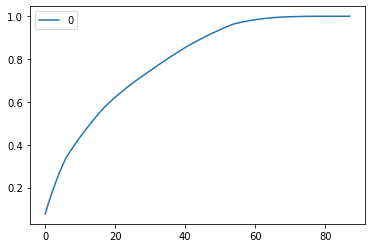

In [116]:
df = pd.DataFrame(pca.explained_variance_ratio_)
df.cumsum().plot()

In [124]:
pca1 = PCA(n_components = 55)

In [131]:
XD = pca1.fit_transform(scaled)
print('55 principal components explain:', pca1.explained_variance_ratio_.sum(), 'of the data variance')


55 principal components explain: 0.9644952117063538 of the data variance


# Clustering

In [150]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 1200, random_state =0).fit(XD)
kmeans.inertia_

21983.47355423745

AttributeError: 'DataFrame' object has no attribute 'labels_'

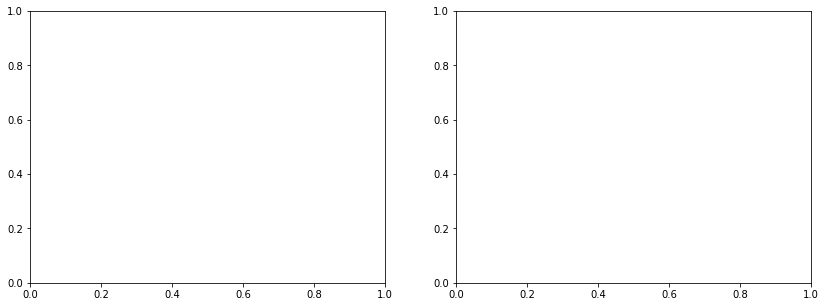

In [102]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

ax1.scatter(XD[:,0], XD[:,1], s=40, c=km1.labels_, cmap=plt.cm.prism) 
ax1.set_title('K-Means Clustering Results with K=2')
ax1.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='+', s=100, c='k', linewidth=2)

ax2.scatter(X[:,0], X[:,1], s=40, c=km2.labels_, cmap=plt.cm.prism) 
ax2.set_title('K-Means Clustering Results with K=3')
ax2.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='+', s=100, c='k', linewidth=2);

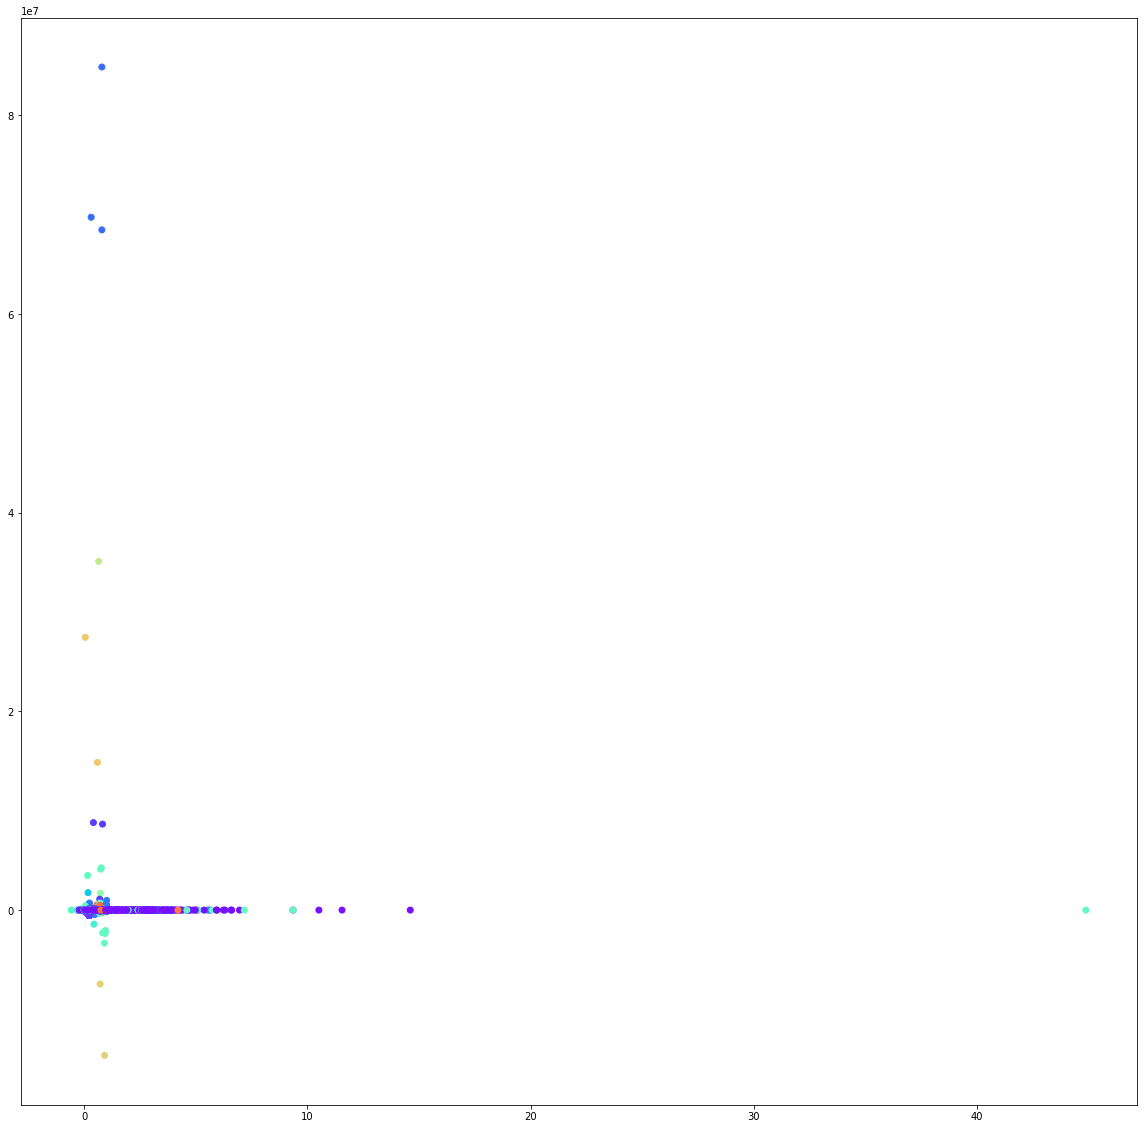

In [140]:
from sklearn.cluster import AgglomerativeClustering

data = findata2.iloc[:,1:89].values

cluster = AgglomerativeClustering(n_clusters=50, affinity='euclidean', linkage='ward')
cluster.fit_predict(data)
plt.figure(figsize=(20, 20))
plt.scatter(data[:,0], data[:,55], c=cluster.labels_, cmap='rainbow')

### Elbow Method

This method indicates that four 3-4 clusters may be able to clear 

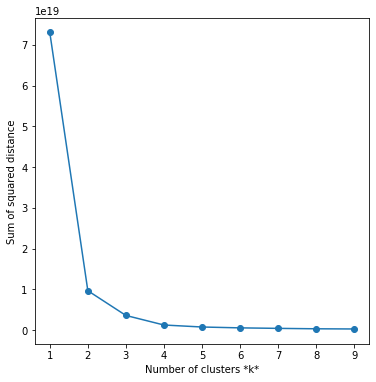

In [112]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(comb2)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');